In [9]:
import os 
import torch
import h5py
import pandas as pd
import numpy as np
from torch_snippets import *
from PIL import Image
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import glob
import scipy.io

In [10]:
images_folder=r'C:\myfiles\ShanghaiTech\part_A\train_data\images'
heat_maps_folder=r'C:\myfiles\ShanghaiTech\part_A\train_data\ground-truth-h5'
ground_truths_folder=r'C:\myfiles\ShanghaiTech\part_A\train_data\ground-truth'

# create the crowd dataset

In [14]:
class crowds(Dataset):
    def __init__(self,folder):
        if folder=='train_data':
            self.images_folder=r'C:\myfiles\ShanghaiTech\part_A\train_data\images'
            self.heat_maps_folder=r'C:\myfiles\ShanghaiTech\part_A\train_data\ground-truth-h5'
            self.ground_truths_folder=r'C:\myfiles\ShanghaiTech\part_A\train_data\ground-truth'
        elif folder=='test_data':
            self.images_folder=r'C:\myfiles\ShanghaiTech\part_A\test_data\images'
            self.heat_maps_folder=r'C:\myfiles\ShanghaiTech\part_A\test_data\ground-truth-h5'
            self.ground_truths_folder=r'C:\myfiles\ShanghaiTech\part_A\test_data\ground-truth'
            
        
    def __getitem__(self,ix):
        all_images=os.listdir(self.images_folder)
        all_heatmaps=os.listdir(self.heat_maps_folder)
        all_gt=os.listdir(self.ground_truths_folder)
        image_path=os.path.join(self.images_folder,all_images[ix])
        heat_map_path=os.path.join(self.heat_maps_folder,all_heatmaps[ix])
        gt_path=os.path.join(self.ground_truths_folder,all_gt[ix])
        image=cv2.imread(image_path)
        with h5py.File(heat_map_path, 'r') as hf:
            gt=hf['density'][:]
        pts=len(scipy.io.loadmat(gt_path)['image_info'][0,0][0,0][0])
        image=torch.from_numpy(image).permute(2,0,1).float()
        gt = resize(gt, 1/8)*64
        #gt=np.resize(gt,(int((gt.shape[0]/8)),int((gt.shape[1]/8))))
        gt=torch.from_numpy(gt)
        gt=torch.unsqueeze(gt,0)
       
        return image.to(device),gt.to(device),torch.tensor(pts).to(device)
    
    
    def __len__(self):
        all_images=os.listdir(self.images_folder)
        return len(all_images)
    
    
        
        

In [15]:
x=crowds('train_data')
test=x.__getitem__(2)
test[1].shape


torch.Size([1, 81, 128])

# make training and test dataloaders

In [16]:
trn_ds = crowds('train_data')
val_ds = crowds('test_data')
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True)
val_dl=DataLoader(val_ds,batch_size=1,shuffle=True)

In [1]:
import torch.nn as nn
import torch
from torchvision import models


# define the make_layers function that will be used in the model

In [18]:
def make_layers(cfg,in_channels=3,batch_norm=False,dilation=False):
    if dilation:
        d_rate=2
    else:
        d_rate=1
    layers=[]
    for v in cfg:
        if v=='M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels,v,kernel_size=3,padding=d_rate,dilation=d_rate)
            
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
                
            in_channels=v
            
    return nn.Sequential(*layers)        

# create the model architecture

In [19]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
                
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x            
            
            
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)    
        

In [53]:
from torchsummary import summary
summary(model, torch.zeros(1,3,654,1024));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 81, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 654, 1024]       1,792
|    └─ReLU: 2-2                         [-1, 64, 654, 1024]       --
|    └─Conv2d: 2-3                       [-1, 64, 654, 1024]       36,928
|    └─ReLU: 2-4                         [-1, 64, 654, 1024]       --
|    └─MaxPool2d: 2-5                    [-1, 64, 327, 512]        --
|    └─Conv2d: 2-6                       [-1, 128, 327, 512]       73,856
|    └─ReLU: 2-7                         [-1, 128, 327, 512]       --
|    └─Conv2d: 2-8                       [-1, 128, 327, 512]       147,584
|    └─ReLU: 2-9                         [-1, 128, 327, 512]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 163, 256]       --
|    └─Conv2d: 2-11                      [-1, 256, 163, 256]       295,168
|    └─ReLU: 2-12                        [-1, 256, 163, 256]    

In [2]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

# train the model

In [23]:


model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 0.043	trn_pts_loss: 287.901	val_loss: 0.026	val_pts_loss: 162.990	(183.94s - 3494.94s remaining)
EPOCH: 2.000	trn_loss: 0.039	trn_pts_loss: 227.862	val_loss: 0.025	val_pts_loss: 251.927	(367.48s - 3307.31s remaining)
EPOCH: 3.000	trn_loss: 0.035	trn_pts_loss: 193.415	val_loss: 0.024	val_pts_loss: 134.311	(551.63s - 3125.91s remaining)
EPOCH: 4.000	trn_loss: 0.034	trn_pts_loss: 176.738	val_loss: 0.023	val_pts_loss: 128.386	(762.96s - 3051.86s remaining)
EPOCH: 5.000	trn_loss: 0.032	trn_pts_loss: 162.744	val_loss: 0.022	val_pts_loss: 129.250	(969.04s - 2907.11s remaining)
EPOCH: 6.000	trn_loss: 0.033	trn_pts_loss: 168.651	val_loss: 0.022	val_pts_loss: 138.589	(1174.56s - 2740.65s remaining)
EPOCH: 7.000	trn_loss: 0.032	trn_pts_loss: 166.479	val_loss: 0.022	val_pts_loss: 123.548	(1381.53s - 2565.70s remaining)
EPOCH: 8.000	trn_loss: 0.031	trn_pts_loss: 143.039	val_loss: 0.022	val_pts_loss: 129.771	(1582.85s - 2374.28s remaining)
EPOCH: 9.000	trn_loss: 0.030	trn_pts_

# make predictions on random image

In [49]:
image=cv2.imread(r'C:\myfiles\ShanghaiTech\part_A\test_data\images\IMG_11.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=torch.from_numpy(image).permute(2,0,1).float()
image=image.to(device)

In [50]:
output = model(image[None])

In [51]:
print("Predicted Count : ", int(output.detach().cpu()\
.sum().numpy()))

Predicted Count :  1041


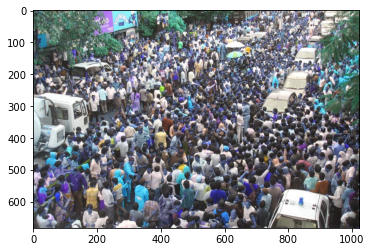

In [52]:
plt.imshow(cv2.imread(r'C:\myfiles\ShanghaiTech\part_A\test_data\images\IMG_11.jpg'))